# PokeGAN

Simple GAN trained on all the pokemon sprite images. No transfer learning is used and the only input to the generator is the random vector.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(".")))

In [3]:
import pickle as pkl

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

import torchvision
from torchvision import models, transforms

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from src import utils
from src import data as DataUtils
from src.gan import generators, discriminators
from src.gan.losses import real_loss, fake_loss

### Load Dataset

In [4]:
image_root_dir = "../data/images/"
image_data, filenames = utils.load_raw_data(image_root_dir)

Total number of files: 857


In [5]:
image_data = [
    image_data[filenames.index("001MS.png")],
    image_data[filenames.index("002MS.png")],
    image_data[filenames.index("003MS.png")]
]

In [6]:
image_w, image_h = image_data[0].size
image_h, image_w, image_data[0].mode

(32, 32, 'RGB')

In [7]:
type(image_data[0])

PIL.Image.Image

In [8]:
sample = np.random.choice(len(image_data), size=18, replace=False)
fig = plt.figure(figsize=(15, 7))
for i, img_index in enumerate(sample):
    ax = fig.add_subplot(3, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(image_data[img_index])
    ax.set_title(f"National Index: {filenames[img_index][:3]}")

ValueError: Cannot take a larger sample than population when 'replace=False'

### Datasets & DataLoaders

In [123]:
# np_data = np.asarray([np.asarray(img) for img in image_data]) / 255
# channel_means = np.mean(np.mean(np_data, axis=0).reshape(-1, 3), axis=0)
# channel_means

Potentially we might want to do mean subtraction later on

In [9]:
use_color = True
n_channels = 3 if use_color else 1
if use_color:
    data_transforms = transforms.Compose([
        transforms.ToTensor(),
    ])
else:
    data_transforms = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])

In [10]:
training_dataset = DataUtils.ImageDataset(image_data, data_transforms)
training_dataloader = DataLoader(training_dataset, batch_size=16, shuffle=True)

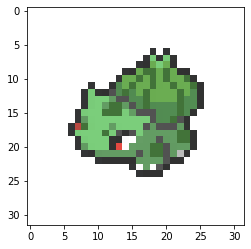

In [11]:
batch_sample = next(iter(training_dataloader))
dataset_sample = batch_sample[0]
dataset_sample = dataset_sample.permute(1, 2, 0)
if not use_color:
    dataset_sample = dataset_sample.squeeze()
plt.imshow(dataset_sample)

In [12]:
batch_sample.shape

torch.Size([3, 3, 32, 32])

## Networks

In [13]:
torch.random.manual_seed(50)

### Discriminator

In [22]:
D = discriminators.DCDiscriminator(image_h, image_w, kernel_size=4, padding=1, is_rgb=use_color)
D

DCDiscriminator(
  (lrelu): LeakyReLU(negative_slope=0.2)
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (noise): GaussianNoise()
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

In [23]:
# Initialise Weights of Layers
for name, param in D.named_parameters():
    if name.find("weight") != -1:
        param.data.normal_(mean=0, std=0.02) 

### Generator

In [25]:
utils.conv_output(16, 16, 2, 0, 2)

(8.0, 8.0)

In [26]:
noise_size = 100
G = generators.DCGenerator(noise_size, image_h, image_w, kernel_size=4, padding=1, is_rgb=use_color)
G

DCGenerator(
  (deconv_layers): ModuleList(
    (0): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (final_conv): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [18]:
# Initialise Weights of Layers
for name, param in G.named_parameters():
    if name.find("weight") != -1:
        param.data.normal_(mean=0, std=0.02) 

In [24]:
D(G(torch.randn((1, 100))))

tensor([[-0.0080]], grad_fn=<AddmmBackward>)

In [27]:
inp = batch_sample
for x in D.conv_layers:
    inp = x(inp)
    print(inp.shape)

torch.Size([3, 32, 16, 16])
torch.Size([3, 64, 8, 8])
torch.Size([3, 128, 4, 4])


### Losses

### Optimisers

In [28]:
# learning rate for optimizers
lr_d = 0.0004
lr_g = 0.0001

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr=lr_d, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.999))

## Training

In [33]:
# training hyperparams
num_epochs = 400

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = utils.generate_random((sample_size, noise_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    for batch_i, real_images in enumerate(training_dataloader):                
        batch_size = real_images.size(0)
        real_images = DataUtils.scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
                
        # 1. Train with real images
        d_optimizer.zero_grad()
        
        # Compute the discriminator losses on real images
        # use smoothed labels
        batch_out_real = D(real_images)
        d_real_loss = real_loss(batch_out_real, smooth=True)
        
        # 2. Train with fake images
        # Generate fake images
        z = utils.generate_random((batch_size, noise_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        
        # add up real and fake losses and perform backprop
        batch_out_fake = D(fake_images)
        d_fake_loss = fake_loss(batch_out_fake)
    
        d_loss = d_fake_loss + d_real_loss
        d_loss.backward(retain_graph=True)
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        
        
        # 1. Train with fake images and flipped labels
        g_optimizer.zero_grad()
        
        # Generate fake images
#         z = utils.generate_random((batch_size, noise_size))
#         z = torch.from_numpy(z).float()
#         fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        
        # perform backprop
#         gen_out_fake = D(fake_images)
        g_loss = real_loss(batch_out_fake)
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  400] | d_loss: 0.4098 | g_loss: 4.8592
Epoch [    2/  400] | d_loss: 0.4357 | g_loss: 3.8806
Epoch [    3/  400] | d_loss: 0.3676 | g_loss: 4.4459
Epoch [    4/  400] | d_loss: 0.5619 | g_loss: 6.5131
Epoch [    5/  400] | d_loss: 0.4135 | g_loss: 4.3233
Epoch [    6/  400] | d_loss: 0.7574 | g_loss: 2.7362
Epoch [    7/  400] | d_loss: 0.4738 | g_loss: 5.7202
Epoch [    8/  400] | d_loss: 0.3736 | g_loss: 5.4673
Epoch [    9/  400] | d_loss: 0.4739 | g_loss: 5.2996
Epoch [   10/  400] | d_loss: 0.4346 | g_loss: 4.0140
Epoch [   11/  400] | d_loss: 0.4192 | g_loss: 3.0740
Epoch [   12/  400] | d_loss: 0.7150 | g_loss: 1.8736
Epoch [   13/  400] | d_loss: 0.4811 | g_loss: 6.3291
Epoch [   14/  400] | d_loss: 0.4063 | g_loss: 5.2796
Epoch [   15/  400] | d_loss: 0.4130 | g_loss: 4.2289
Epoch [   16/  400] | d_loss: 0.3715 | g_loss: 3.9816
Epoch [   17/  400] | d_loss: 0.6031 | g_loss: 3.4992
Epoch [   18/  400] | d_loss: 0.3745 | g_loss: 5.2106
Epoch [   19/  400] | d_loss

Epoch [  154/  400] | d_loss: 0.5173 | g_loss: 4.1110
Epoch [  155/  400] | d_loss: 0.3623 | g_loss: 4.6972
Epoch [  156/  400] | d_loss: 0.7613 | g_loss: 5.8300
Epoch [  157/  400] | d_loss: 0.3669 | g_loss: 4.2967
Epoch [  158/  400] | d_loss: 0.3917 | g_loss: 3.4222
Epoch [  159/  400] | d_loss: 0.4498 | g_loss: 4.2856
Epoch [  160/  400] | d_loss: 0.3857 | g_loss: 3.9655
Epoch [  161/  400] | d_loss: 0.3977 | g_loss: 3.0486
Epoch [  162/  400] | d_loss: 0.3616 | g_loss: 5.3020
Epoch [  163/  400] | d_loss: 0.4911 | g_loss: 4.3277
Epoch [  164/  400] | d_loss: 0.4600 | g_loss: 3.0051
Epoch [  165/  400] | d_loss: 0.3858 | g_loss: 4.8882
Epoch [  166/  400] | d_loss: 0.6091 | g_loss: 5.8295
Epoch [  167/  400] | d_loss: 0.4286 | g_loss: 4.4119
Epoch [  168/  400] | d_loss: 0.4667 | g_loss: 3.5328
Epoch [  169/  400] | d_loss: 0.3724 | g_loss: 4.1948
Epoch [  170/  400] | d_loss: 0.4556 | g_loss: 2.5973
Epoch [  171/  400] | d_loss: 0.3961 | g_loss: 4.8204
Epoch [  172/  400] | d_loss

Epoch [  306/  400] | d_loss: 0.3910 | g_loss: 3.7219
Epoch [  307/  400] | d_loss: 0.3886 | g_loss: 3.2385
Epoch [  308/  400] | d_loss: 0.3563 | g_loss: 4.5011
Epoch [  309/  400] | d_loss: 0.4197 | g_loss: 3.8165
Epoch [  310/  400] | d_loss: 0.4683 | g_loss: 4.4985
Epoch [  311/  400] | d_loss: 0.3334 | g_loss: 5.7253
Epoch [  312/  400] | d_loss: 0.5123 | g_loss: 3.3551
Epoch [  313/  400] | d_loss: 0.3835 | g_loss: 5.8203
Epoch [  314/  400] | d_loss: 0.4050 | g_loss: 4.6738
Epoch [  315/  400] | d_loss: 0.3661 | g_loss: 3.7773
Epoch [  316/  400] | d_loss: 0.5166 | g_loss: 3.6866
Epoch [  317/  400] | d_loss: 0.4147 | g_loss: 6.2124
Epoch [  318/  400] | d_loss: 0.3694 | g_loss: 4.8823
Epoch [  319/  400] | d_loss: 0.4621 | g_loss: 2.9531
Epoch [  320/  400] | d_loss: 0.4230 | g_loss: 3.8969
Epoch [  321/  400] | d_loss: 0.3433 | g_loss: 5.6017
Epoch [  322/  400] | d_loss: 0.4214 | g_loss: 3.8814
Epoch [  323/  400] | d_loss: 0.4420 | g_loss: 3.6653
Epoch [  324/  400] | d_loss

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

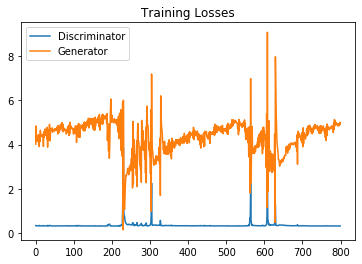

In [109]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Sampling

In [30]:
def reshape_sample(samples, img_size, is_rgb=True):
    samples = (samples + 1) / 2  # Reverse scaling
    samples = samples.permute(0, 2, 3, 1)
    samples.detach()
    return samples.numpy()

In [34]:
# randomly generated, new latent vectors
sample_size=16
rand_z = utils.generate_random((sample_size, noise_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
with torch.no_grad():
    rand_images = G(rand_z)
    
reshaped_images = reshape_sample(rand_images, image_w, is_rgb=use_color).squeeze()

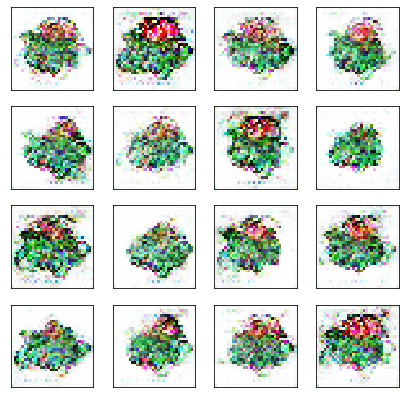

In [35]:
fig = plt.figure(figsize=(7, 7))
for i, s in enumerate(reshaped_images):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(s, cmap='gray')

### Load Training Samples

In [40]:
training_samples = pkl.load(open("train_samples.pkl", 'rb'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

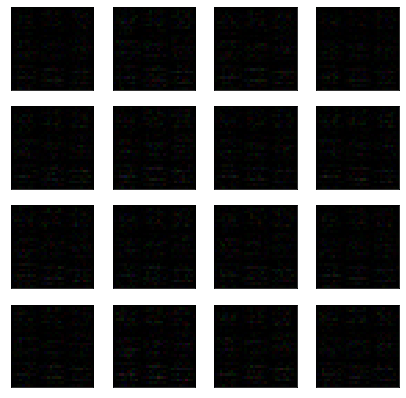

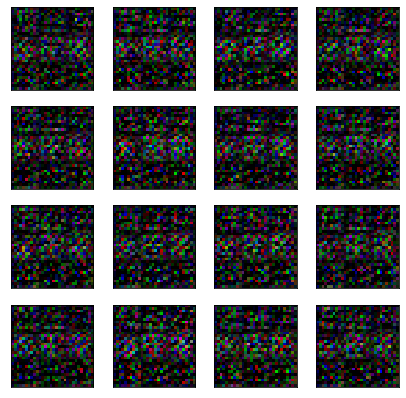

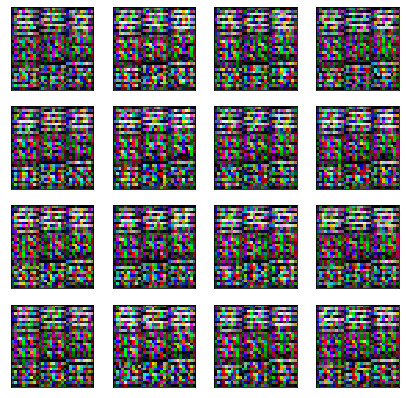

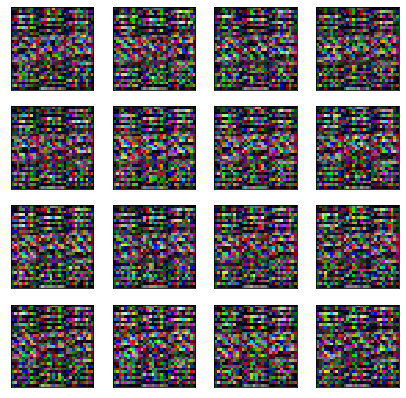

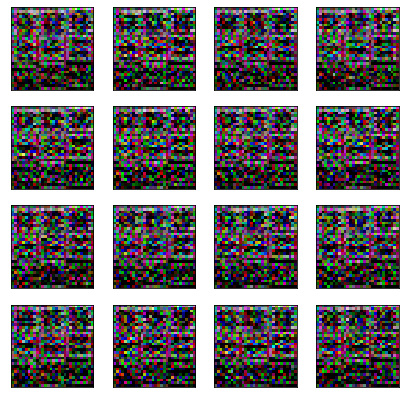

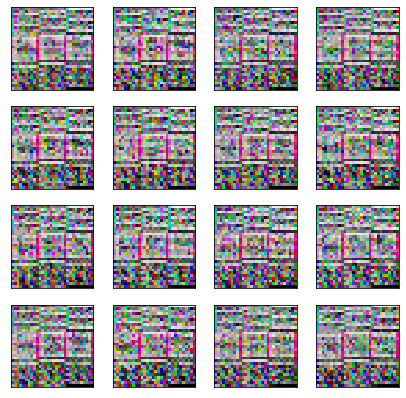

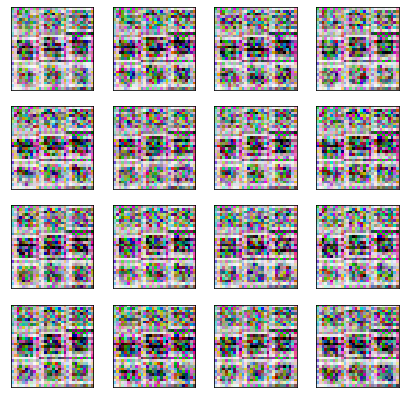

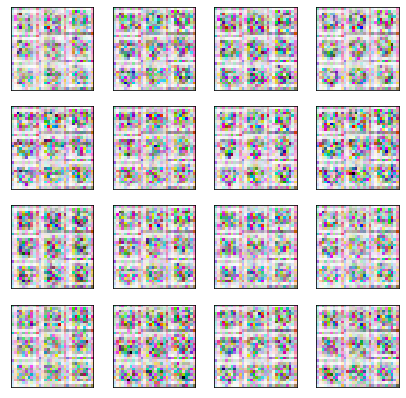

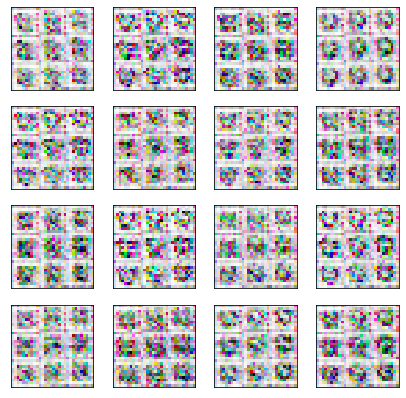

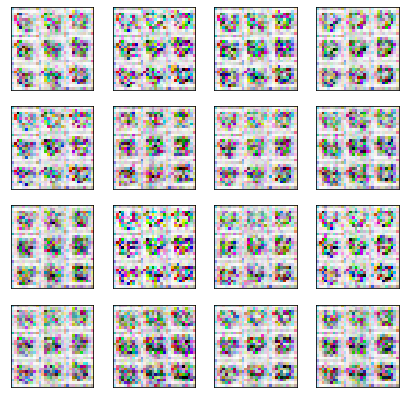

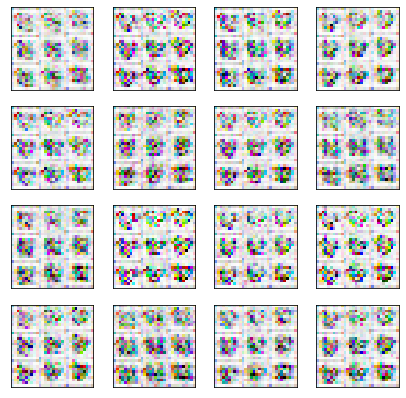

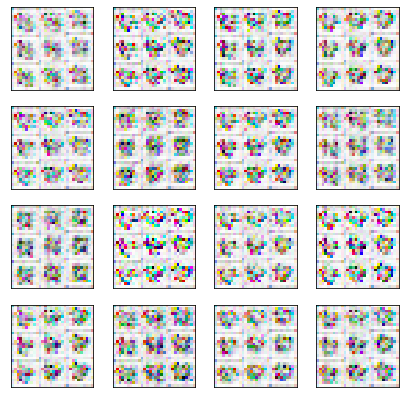

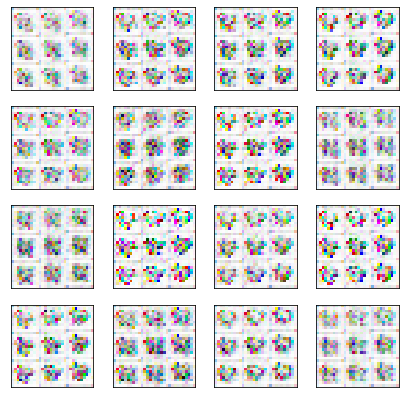

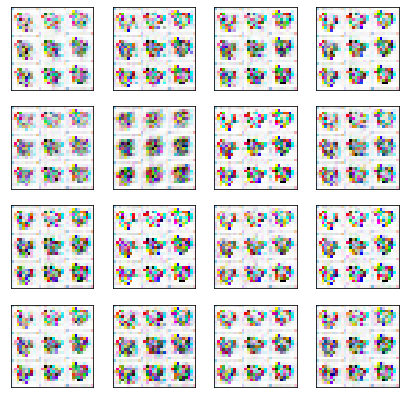

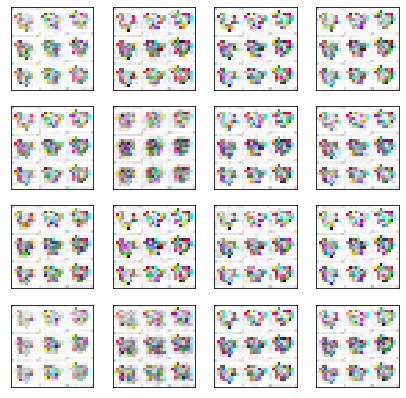

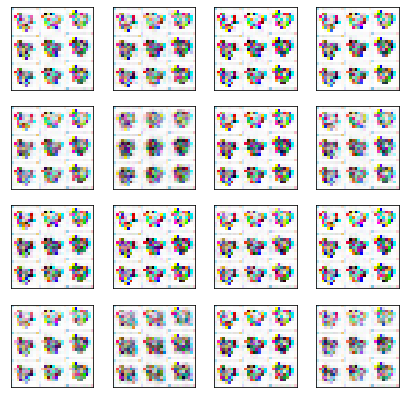

In [42]:
for i in range(0, len(training_samples), 25):
    reshaped_images = reshape_sample(training_samples[i].detach(), img_size, is_rgb=use_color)
    fig = plt.figure(figsize=(7, 7))
    for i, s in enumerate(reshaped_images):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(s, cmap='gray')

### Save Generator

In [ ]:
torch.save(G.state_dict(), "../models/vgg_generator.pt")

### Onxx Export

In [ ]:
G.train(False)
dummy_input = torch.randn(10, 3, 40, 40, device='cpu')
torch.onnx.export(
    G, dummy_input, "pokegan.onnx", verbose=True)